# DNNの説明性
一般にAIと呼ばれる技術の中でも特にDNN(深層学習)は何故その答えになったのかがブラックボックスになるというデメリットがある。そこで、反実仮想を用いてモデルについて本来ありえない値を入れてシミュレーションをすることでできる限り説明できるようにする手法としてdiceというライブラリを使用する。

## ライブラリのインポート

In [1]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import GradientBoostingClassifier as GBC
import pandas as pd
import numpy as np
import dice_ml
import shap

## データの読み込み

In [2]:
df = pd.read_csv("rossi.csv")
df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


## 原因系変数と結果系変数を分ける
ここでは再逮捕を結果系変数とする。なお、説明性についての解釈をしやすくするため今回は原因系変数の前処理(標準化・正規化など)は行わずありのままの値を使用する。

In [3]:
x = df.drop(["arrest"], axis=1)
y = df["arrest"]

## 訓練データとテストデータを分ける

In [4]:
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=1)

## ニューラルネットワークモデルを作成
できるだけ複雑なモデルを作成する

In [5]:
model = MLP(hidden_layer_sizes=(500, 500, 400, 300))

## 適合

In [6]:
model.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(500, 500, 400, 300))

## 予測および精度の検証
モデルについて精度の検証を行うことはモデルが原因系変数でどれだけ結果を説明できているかの指標となるため必ず行う。

In [7]:
y_pred = model.predict(x_test)

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        69
           1       0.79      0.83      0.81        18

    accuracy                           0.92        87
   macro avg       0.87      0.89      0.88        87
weighted avg       0.92      0.92      0.92        87



## 反実仮想の作成

In [9]:
d = dice_ml.Data(dataframe = pd.concat([x_test, y_test], axis=1),
                 continuous_features = ["week", "age", "prio"], #量的変数を選択
                 outcome_name = "arrest" #結果系変数を選択
                )
m = dice_ml.Model(model=model, backend="sklearn")
exp = dice_ml.Dice(d, m)

In [10]:
pre_counter = x_test.iloc[0:10, :] 
dice_exp = exp.generate_counterfactuals(pre_counter, total_CFs=4, desired_class = "opposite")
dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.55it/s]

Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,20,1,0,0,1,9,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,17,0,-,1,0,0,1,-,1
1,26,0,-,1,0,0,1,-,1
2,-,0,30,1,0,0,1,-,1
3,-,1,32,1,0,0,1,-,1


Query instance (original outcome : 1)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,36,1,23,1,0,0,0,3,1



Diverse Counterfactual set (new outcome: 0.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,-,1,-,1,0,0,0,0,0
1,43,1,-,1,0,0,0,-,0
2,41,1,-,1,-,0,0,-,0
3,49,1,-,1,0,0,0,10,0


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,1,28,1,0,0,1,4,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,29,1,-,1,0,0,1,0,1
1,-,1,-,1,0,0,1,10,1
2,11,1,-,1,0,0,1,-,1
3,41,1,-,1,0,0,1,-,1


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,22,1,0,0,1,1,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,28,0,-,1,0,0,1,12,1
1,25,0,-,1,0,0,1,12,1
2,25,0,-,1,0,0,1,-,1
3,29,0,36,1,0,0,1,-,1


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,21,1,0,0,0,2,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,23,1,-,1,0,0,0,-,1
1,38,0,-,1,0,0,0,4,1
2,8,0,-,-,0,0,0,-,1
3,20,0,-,-,0,0,0,-,1


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,1,18,1,0,0,0,4,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,29,1,-,1,0,0,0,-,1
1,27,1,-,1,0,0,0,-,1
2,31,1,-,1,0,0,0,10,1
3,23,0,-,1,0,0,0,-,1


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,19,0,1,0,1,3,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,-,0,33,0,1,0,1,8,1
1,22,0,-,0,1,0,1,-,1
2,24,0,-,0,1,0,1,-,1
3,19,0,-,0,-,0,1,-,1


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,20,1,0,0,0,1,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,14,0,-,1,0,1,0,-,1
1,9,0,-,0,0,0,0,-,1
2,18,0,-,1,0,1,0,-,1
3,32,0,28,1,0,0,0,-,1


Query instance (original outcome : 1)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,26,0,32,1,1,0,0,2,1



Diverse Counterfactual set (new outcome: 0.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,-,1,1,0,0,-,0
1,37,0,-,0,1,0,0,-,0
2,47,0,-,0,1,0,0,-,0
3,42,-,-,1,1,0,0,-,0


Query instance (original outcome : 1)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,24,0,40,1,1,0,0,2,1



Diverse Counterfactual set (new outcome: 0.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,45,0,27,1,1,0,0,-,0
1,51,0,35,1,1,0,0,-,0
2,52,0,-,1,1,0,0,-,0
3,50,0,-,1,1,0,-,-,0


元のデータ(上)と反実仮想(下)のデータが出力される。ここで、陽性と陰性が逆転するためのデータが指定された個数(total_CFs)だけ表示される。

## GBMを用いてより正確に予測
基本的にニューラルネットワークでは原因系変数の前処理として標準化や正規化が必要になる。しかし、決定木系アルゴリズムではそのような変換をしてもしなくても精度自体は変わらないため、より精度の高いモデルで反実仮想を作成できる。

### GBMのモデルを作成

In [11]:
model = GBC()

### 適合

In [12]:
model.fit(x_train, y_train)

GradientBoostingClassifier()

### 予測および精度の検証
前処理が必要なニューラルネットワークモデルと異なりGBMでは前処理をしなくても精度が高い事を確認する。

In [13]:
y_pred = model.predict(x_test)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        69
           1       0.95      1.00      0.97        18

    accuracy                           0.99        87
   macro avg       0.97      0.99      0.98        87
weighted avg       0.99      0.99      0.99        87



正解率が99%となりニューラルネットワークモデルと比べて7%高いことが分かる

### 反実仮想を作成

In [15]:
d = dice_ml.Data(dataframe = pd.concat([x_test, y_test], axis=1),
                 continuous_features = ["week", "age", "prio"], #量的変数を選択
                 outcome_name = "arrest" #結果系変数を選択
                )
m = dice_ml.Model(model=model, backend="sklearn")
exp = dice_ml.Dice(d, m)

In [16]:
pre_counter = x_test.iloc[0:10, :] 
dice_exp = exp.generate_counterfactuals(pre_counter, total_CFs=4, desired_class = "opposite")
dice_exp.visualize_as_dataframe(show_only_changes=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.01it/s]

Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,20,1,0,0,1,9,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,17,0,-,1,0,0,-,-,1
1,21,-,-,1,0,0,1,-,1
2,42,0,-,1,0,1,1,-,1
3,35,-,-,1,0,0,1,-,1


Query instance (original outcome : 1)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,36,1,23,1,0,0,0,3,1



Diverse Counterfactual set (new outcome: 0.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,1,-,1,0,0,1,-,0
1,52,1,-,1,0,0,0,0,0
2,52,1,-,1,0,0,0,-,0
3,52,1,-,1,0,0,0,12,0


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,1,28,1,0,0,1,4,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,18,1,-,1,0,0,-,-,1
1,36,1,-,1,0,0,1,9,1
2,10,1,-,1,0,0,0,-,1
3,25,1,-,-,0,0,1,-,1


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,22,1,0,0,1,1,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,37,0,-,1,0,0,1,6,1
1,35,0,31,1,0,0,1,-,1
2,23,0,-,1,0,0,1,4,1
3,18,0,-,1,0,0,1,-,1


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,21,1,0,0,0,2,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,35,0,-,1,0,-,0,-,1
1,28,0,-,1,0,0,0,-,1
2,37,0,-,-,0,0,0,-,1
3,11,0,-,1,0,0,0,-,1


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,1,18,1,0,0,0,4,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,36,1,-,1,0,0,0,-,1
1,9,1,-,1,0,0,0,-,1
2,41,1,-,1,0,0,0,8,1
3,48,0,-,1,0,0,0,-,1


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,19,0,1,0,1,3,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,50,0,-,1,1,0,1,-,1
1,22,0,-,0,1,0,1,8,1
2,14,0,-,0,1,1,1,-,1
3,35,-,-,0,1,0,1,-,1


Query instance (original outcome : 0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,20,1,0,0,0,1,0



Diverse Counterfactual set (new outcome: 1.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,10,0,-,-,0,0,0,-,1
1,17,0,-,1,0,0,0,-,1
2,22,0,-,0,0,0,0,-,1
3,8,0,-,0,0,0,0,-,1


Query instance (original outcome : 1)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,26,0,32,1,1,0,0,2,1



Diverse Counterfactual set (new outcome: 0.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,-,1,0,0,0,-,0
1,52,0,27,1,1,0,0,-,0
2,52,0,-,-,1,0,0,-,0
3,52,0,41,1,1,0,0,-,0


Query instance (original outcome : 1)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,24,0,40,1,1,0,0,2,1



Diverse Counterfactual set (new outcome: 0.0)


,week,fin,age,race,wexp,mar,paro,prio,arrest
0,52,0,-,1,1,1,0,8,0
1,52,0,-,1,1,1,0,-,0
2,52,1,-,1,1,0,0,-,0
3,52,0,-,1,-,1,0,-,0


ここから精度の高い反実仮想を基に原因と結果の関係性を考察する。

## 結果への寄与度
今度はリアルな値より精度を意識して標準化して値の大小で見る。
### 原因系変数の前処理(標準化)

In [17]:
tx = x.copy()
for col in x.columns:
    if col == "week" or col == "age" or col == "prio":
        tx[col] = (x[col] - x[col].mean()) / x[col].std()
    else:
        tx[col] = x[col]
tx.describe()

,week,fin,age,race,wexp,mar,paro,prio
count,4.320000e+02,432.00000,4.320000e+02,432.000000,432.000000,432.000000,432.000000,4.320000e+02
mean,2.179327e-16,0.50000,1.110223e-16,0.877315,0.571759,0.122685,0.618056,4.111937e-17
std,1.000000e+00,0.50058,1.000000e+00,0.328456,0.495398,0.328456,0.486426,1.000000e+00
min,-3.542341e+00,0.00000,-1.242721e+00,0.000000,0.000000,0.000000,0.000000,-1.030292e+00
25%,3.274157e-01,0.00000,-7.519941e-01,1.000000,0.000000,0.000000,0.000000,-6.849965e-01
50%,4.853649e-01,0.50000,-2.612668e-01,1.000000,1.000000,0.000000,1.000000,-3.397007e-01
75%,4.853649e-01,1.00000,3.930362e-01,1.000000,1.000000,0.000000,1.000000,3.508909e-01
max,4.853649e-01,1.00000,3.173824e+00,1.000000,1.000000,1.000000,1.000000,5.185032e+00


### データの分割

In [18]:
x_train, x_test, y_train, y_test = tts(tx.values, y.values, test_size=0.2, random_state=1)

### モデルの再定義
今度は原因系変数を標準化しているためモデルを再定義する必要がある。

In [19]:
model = MLP(hidden_layer_sizes=(500, 500, 400, 300))

### 適合

In [20]:
model.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(500, 500, 400, 300))

### 予測および精度の確認
今度は標準化しているため精度が上がることを確認する。

In [21]:
y_pred = model.predict(x_test)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        69
           1       0.95      1.00      0.97        18

    accuracy                           0.99        87
   macro avg       0.97      0.99      0.98        87
weighted avg       0.99      0.99      0.99        87



精度が7%上がったことが分かり、標準化したことで原因系変数によってより結果を説明できていることが分かる。

# SHAP
通常、非線形の機械学習では基準となる数式がブラックボックスとなっているため何故その結果になったのかが分からない。そこで、結果を算出する上で特徴量をどのように使ったか、予測にどのくらい影響を与えているかなど線形モデルや決定木系の数理モデルのようなモデルの使い方をするためにSHAPを使用する。

## SHAPライブラリを使用する準備

In [23]:
shap.initjs()

### 各推論の個別確認

In [24]:
explainer = shap.KernelExplainer(model.predict_proba, x_train)
shap_values = explainer.shap_values(x_train)

Using 345 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/345 [00:00<?, ?it/s]

In [25]:
shap.force_plot(explainer.expected_value[0], shap_values[0], x_train, feature_names=tx.columns)

### 変数ごとの影響度の確認
縦軸を変数名として横軸がSHAP値(結果に与えた影響)となり色が変数の値となっている。

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


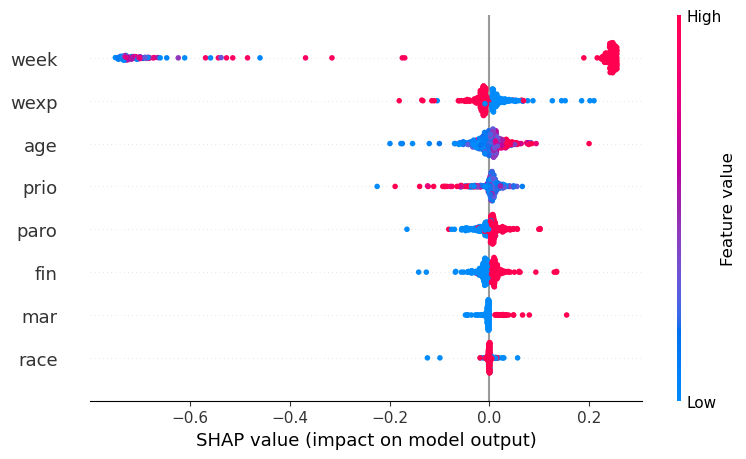

In [26]:
shap.summary_plot(shap_values[0],
                  x_train,
                  feature_names=tx.columns)

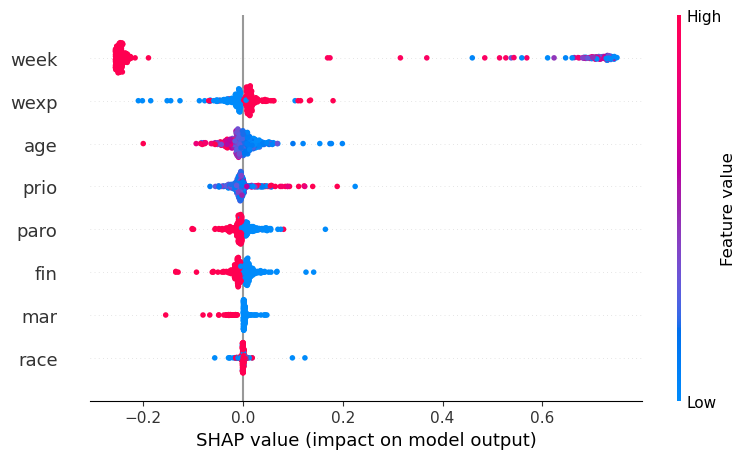

In [27]:
shap.summary_plot(shap_values[1],
                  x_train,
                  feature_names=tx.columns)

In[26]とは逆の値になっている事が分かる。

### 分類寄与率の確認
決定木で使われる分類寄与率をSHAPで使用する。

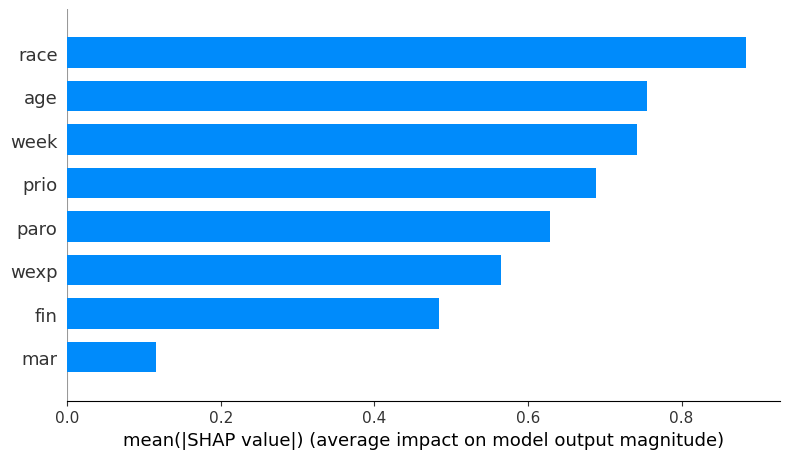

In [28]:
shap.summary_plot(shap_values=x_train,
                  feature_names=tx.columns,
                  plot_type='bar')